<hr style="height:2px;">

# Demo: Training data generation for denoising of *Tribolium castaneum*

This notebook demonstrates training data generation for a 3D denoising task, where corresponding pairs of low and high quality stacks can be acquired. 

Each pair should be registered, which is best achieved by acquiring both stacks _interleaved_, i.e. as different channels that correspond to the different exposure/laser settings. 

We will use a single Tribolium stack pair for training data generation, whereas in your application you should aim to acquire at least 10-50 stacks from different developmental timepoints to ensure a well trained model. 

More Documentation is available at http://csbdeep.bioimagecomputing.com/doc/.

In [1]:
from __future__ import print_function, unicode_literals, absolute_import, division
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from tifffile import imread
from csbdeep.utils import download_and_extract_zip_file, plot_some
from csbdeep.data import RawData, create_patches

/sw/apps/python3/3.6.5/lib/python3.6/site-packages/tifffile/tifffile.py:7685: UserWarning: No module named 'tifffile._tifffile'
  Functionality might be degraded or be slow.

  warnings.warn('%s%s' % (e, warn))


<hr style="height:2px;">

# Example data

We use some example data, consisting of low-SNR and high-SNR 3D images of Tribolium.  
Note that `GT` stands for [ground truth](https://en.wikipedia.org/wiki/Ground_truth) and represents high signal-to-noise ratio (SNR) stacks.

In [2]:
%%bash
mkdir -p data
ln -s ~/data/tribolium data/tribolium
tree data/tribolium

data/tribolium
├── test
│   ├── GT
│   │   └── nGFP_0.1_0.2_0.5_20_14_late.tif
│   └── low
│       └── nGFP_0.1_0.2_0.5_20_14_late.tif
└── train
    ├── GT
    │   └── nGFP_0.1_0.2_0.5_20_13_late.tif
    └── low
        └── nGFP_0.1_0.2_0.5_20_13_late.tif

6 directories, 4 files


We can plot the training stack pair via maximum-projection:

image size = (48, 773, 665)


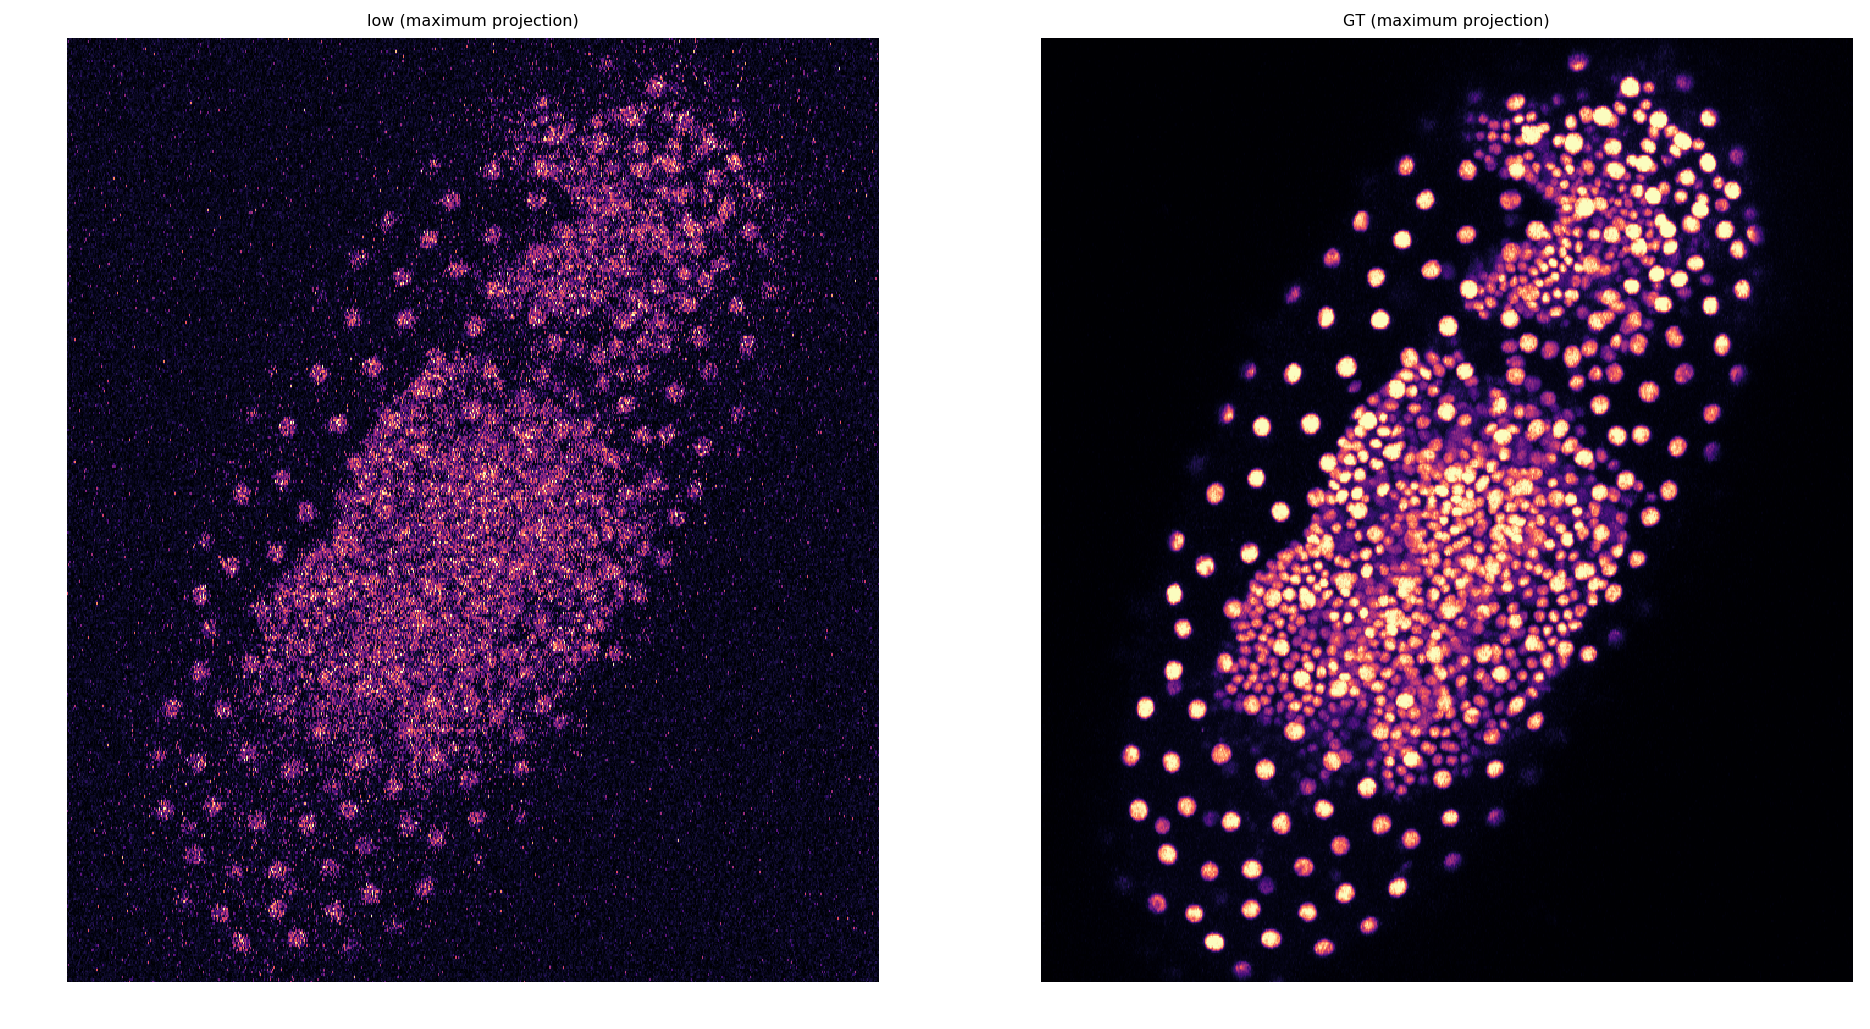

In [3]:
y = imread('data/tribolium/train/GT/nGFP_0.1_0.2_0.5_20_13_late.tif')
x = imread('data/tribolium/train/low/nGFP_0.1_0.2_0.5_20_13_late.tif')
print('image size =', x.shape)

plt.figure(figsize=(16,10))
plot_some(np.stack([x,y]),
          title_list=[['low (maximum projection)','GT (maximum projection)']], 
          pmin=2,pmax=99.8);

<hr style="height:2px;">

# Generate training data for CARE

We first need to create a `RawData` object, which defines how to get the pairs of low/high SNR stacks and the semantics of each axis (e.g. which one is considered a color channel, etc.).

Here we have two folders "low" and "GT", where corresponding low and high-SNR stacks are TIFF images with identical filenames.  
For this case, we can simply use `RawData.from_folder` and set `axes = 'ZYX'` to indicate the semantic order of the image axes. 

In [4]:
raw_data = RawData.from_folder (
    basepath    = 'data/tribolium/train',
    source_dirs = ['low'],
    target_dir  = 'GT',
    axes        = 'ZYX',
)

From corresponding stacks, we now generate some 3D patches. As a general rule, use a patch size that is a power of two along XYZT, or at least divisible by 8.  
Typically, you should use more patches the more trainings stacks you have. By default, patches are sampled from non-background regions (i.e. that are above a relative threshold), see the documentation of `create_patches` for details.

Note that returned values `(X, Y, XY_axes)` by `create_patches` are not to be confused with the image axes X and Y.  
By convention, the variable name `X` (or `x`) refers to an input variable for a machine learning model, whereas `Y` (or `y`) indicates an output variable.

In [ ]:
X, Y, XY_axes = create_patches (
    raw_data            = raw_data,
    patch_size          = (16,64,64),
    n_patches_per_image = 1024,
    save_file           = 'data/my_training_data.npz',
)

In [ ]:
assert X.shape == Y.shape
print("shape of X,Y =", X.shape)
print("axes  of X,Y =", XY_axes)

## Show

This shows the maximum projection of some of the generated patch pairs (even rows: *input*, odd rows: *target*)

In [ ]:
for i in range(2):
    plt.figure(figsize=(16,4))
    sl = slice(8*i, 8*(i+1)), 0
    plot_some(X[sl],Y[sl],title_list=[np.arange(sl[0].start,sl[0].stop)])
    plt.show()
None;